In [1]:
import numpy as np    
from scipy import spatial
import sklearn as sk
import distances
from sklearn.neighbors import NearestNeighbors
import time
import nearest_neighbors as NN
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import scipy.ndimage as sc

In [2]:
def euclidean_distance(X, Y):
    A = np.add.outer(np.sum(X ** 2, axis=1), np.sum(Y ** 2, axis=1))
    B = np.dot(X, Y.T)
    return np.sqrt(A - 2 * B)

In [3]:
def cosine_distance(X, Y):
    A = X.dot(Y.T) / np.outer(np.linalg.norm(X, axis=1), np.linalg.norm(Y, axis=1))
    return 1 - A

In [4]:
class KNNClassifier:
    def __init__(self, k = 1, strategy = 'my_own', metric = 'euclidean', 
                 weights = False, test_block_size = 30):
        self.n_neighbors = k
        self.strategy = strategy
        self.metric = metric
        self.weights = weights
        self.test_block_size = test_block_size


    def fit(self, X, y):
        self.y = np.array(y)
        if self.strategy != 'my_own':
            self.neigh = NearestNeighbors(n_neighbors = self.n_neighbors, 
                                          algorithm = self.strategy, 
                                          metric = self.metric)
            self.neigh = self.neigh.fit(X)
        else:
            self.X = np.array(X)


    def find_kneighbors(self, X, return_distance = False):
        n = self.n_neighbors
        if self.strategy != 'my_own':
            return self.neigh.kneighbors(X, n, return_distance)
        else:
            right_bond = self.test_block_size
            if self.metric == 'euclidean':
                D = distances.euclidean_distance(X[0 : right_bond], self.X)
            elif self.metric == 'cosine':
                D = distances.cosine_distance(X[0 : right_bond], self.X)
            indices = D.argsort(axis = 1)[:,:n]
            array = np.sort(D, axis = 1)[:,:n]
            test_size = right_bond
            while test_size < X.shape[0]:
                right_bond = self.test_block_size + test_size
                if self.metric == 'euclidean':
                    D = distances.euclidean_distance(X[test_size : right_bond], self.X)
                elif self.metric == 'cosine':
                    D = distances.cosine_distance(X[test_size : right_bond], self.X)
                indices = np.vstack((indices, D.argsort(axis = 1)[:,:n]))
                array = np.vstack((array, np.sort(D, axis = 1)[:,:n]))
                test_size = right_bond
        if return_distance:
            return (array, indices)
        else:
            return indices


    def predict(self, X):
        distance, nearest_neighbors = self.find_kneighbors(X, True)
        i = 0
        predict = np.zeros(X.shape[0])
        for row in nearest_neighbors:
            if self.weights:
                w = list(map(lambda x: 1 / (x + 10 ** (-5)), distance[i]))
                predict[i] = np.argmax(np.bincount(self.y[row], weights = w))
            else:
                predict[i] = np.argmax(np.bincount(self.y[row]))
            i += 1
        return predict


In [5]:
def kfold(n, n_folds = 3):
    indices = np.random.permutation(np.arange(n))
    indices = np.array(np.array_split(indices, n_folds))
    res = []
    for i in range(len(indices)):
        a = np.concatenate([indices[:i], indices[i + 1:]], axis = 0)
        res.append((np.hstack(a), indices[i]))
    return res


def accuracy(y, y_test):
    return np.array([y == y_test]).mean()


def knn_cross_val_score(X, y, k_list, score, cv = None, **kwargs):
    res = {}
    if cv == None:
        cv = kfold(X.shape[0])
    i = 0
    start = True
    time_arr = np.zeros((len(cv), len(k_list)))
    cv_number = 0
    for indices in cv:
        ind_0 = indices[0]
        ind_1 = indices[1]
        k_number = 0
        for k_neighbors in k_list[::-1]:
            t_1 = time.time()
            classifier = NN.KNNClassifier(k_neighbors, **kwargs)
            classifier.fit(X[ind_0], y[ind_0])
            if start:
                distance, nearest_neighbors = classifier.find_kneighbors(X[ind_1], True)
                start = False
            else:
                distance = distance[:, :k_neighbors]
                nearest_neighbors = nearest_neighbors[:, :k_neighbors]
            predict = np.zeros(len(ind_1))
            j = 0
            for row in nearest_neighbors:
                if classifier.weights:
                    w = list(map(lambda x: 1 / (x + 10 ** (-5)), distance[j]))
                    predict[j] = np.argmax(np.bincount(classifier.y[row], weights = w))
                else:
                    predict[j] = np.argmax(np.bincount(classifier.y[row]))
                j += 1
            if k_neighbors in res.keys():
                res[k_neighbors][i] = accuracy(y[ind_1], predict)
            else:
                res[k_neighbors] = np.zeros(len(cv))
                res[k_neighbors][0] = accuracy(y[ind_1], predict)
            t_2 = time.time()
            time_arr[cv_number][k_number] = t_2 - t_1
            k_number += 1
        cv_number += 1
        i += 1
        start = True
    return res, time_arr


In [6]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', return_X_y=True)

In [7]:
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]
y_train = y_train.astype(int)
y_test = y_test.astype(int)

# 1 задание

Генерируем случайную подвыборку признаков.

In [121]:
r_10 = np.random.randint(0, X_train.shape[1], 10)
r_20 = np.random.randint(0, X_train.shape[1], 20)
r_100 = np.random.randint(0, X_train.shape[1], 100)

## My_own

In [122]:
time_own = []

In [123]:
classifier = KNNClassifier(k = 5, strategy = 'my_own')

In [124]:
t_1 = time.time()
X_train_split = X_train[:, r_10]
X_test_split = X_test[:, r_10]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_own.append(t_2 - t_1)

In [125]:
t_1 = time.time()
X_train_split = X_train[:, r_20]
X_test_split = X_test[:, r_20]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_own.append(t_2 - t_1)

In [126]:
t_1 = time.time()
X_train_split = X_train[:, r_100]
X_test_split = X_test[:, r_100]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_own.append(t_2 - t_1)

## Brute

In [127]:
time_brute = []

In [128]:
classifier = KNNClassifier(k = 5, strategy = 'brute')

In [129]:
t_1 = time.time()
X_train_split = X_train[:, r_10]
X_test_split = X_test[:, r_10]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_brute.append(t_2 - t_1)

In [130]:
t_1 = time.time()
X_train_split = X_train[:, r_20]
X_test_split = X_test[:, r_20]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_brute.append(t_2 - t_1)

In [131]:
t_1 = time.time()
X_train_split = X_train[:, r_100]
X_test_split = X_test[:, r_100]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_brute.append(t_2 - t_1)

## Kd_tree

In [132]:
time_kd = []

In [133]:
classifier = KNNClassifier(k = 5, strategy = 'kd_tree')

In [134]:
t_1 = time.time()
X_train_split = X_train[:, r_10]
X_test_split = X_test[:, r_10]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_kd.append(t_2 - t_1)

In [135]:
t_1 = time.time()
X_train_split = X_train[:, r_20]
X_test_split = X_test[:, r_20]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_kd.append(t_2 - t_1)

In [137]:
t_1 = time.time()
X_train_split = X_train[:, r_100]
X_test_split = X_test[:, r_100]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_kd.append(t_2 - t_1)

## Ball_tree

In [138]:
time_ball = []

In [139]:
classifier = KNNClassifier(k = 5, strategy = 'ball_tree')

In [140]:
t_1 = time.time()
X_train_split = X_train[:, r_10]
X_test_split = X_test[:, r_10]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_ball.append(t_2 - t_1)

In [141]:
t_1 = time.time()
X_train_split = X_train[:, r_20]
X_test_split = X_test[:, r_20]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_ball.append(t_2 - t_1)

In [142]:
t_1 = time.time()
X_train_split = X_train[:, r_100]
X_test_split = X_test[:, r_100]
classifier.fit(X_train_split, y_train)
classifier.find_kneighbors(X_test_split)
t_2 = time.time()
time_ball.append(t_2 - t_1)

In [143]:
count = [10, 20, 100]

In [144]:
time_own

[113.22010803222656, 123.8765959739685, 139.23636436462402]

In [145]:
time_brute

[17.448731422424316, 17.063352584838867, 17.68069887161255]

In [146]:
time_kd

[10.268944025039673, 12.252216100692749, 143.57836961746216]

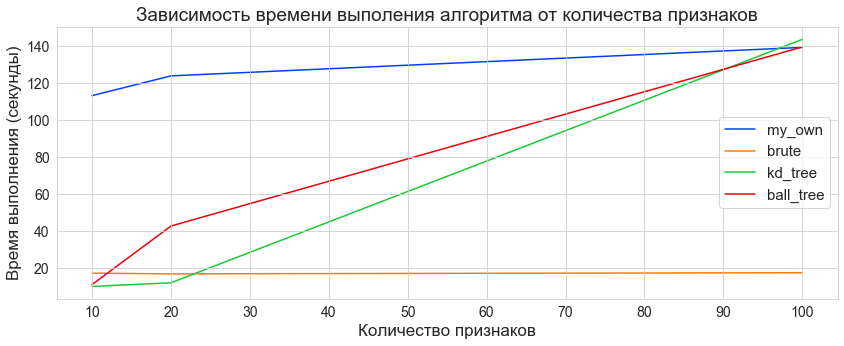

In [177]:
fig = plt.figure(figsize= (14,5))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость времени выполения алгоритма от количества признаков", fontsize = 19)
plt.xlabel("Количество признаков", fontsize = 17) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.ylabel("Время выполнения (секунды)", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
sns.set_palette('bright')
ax1.plot(count, time_own, label = "my_own")
ax1.plot(count, time_brute, label = "brute")
ax1.plot(count, time_kd, label = "kd_tree")
ax1.plot(count, time_ball, label = "ball_tree")
ax1.legend(fontsize = 15)

In [178]:
fig.savefig('exersize_1.pdf')

Видим, что brute работает быстрее остальных. В дальнейшем будем использовать его.

# 2 задание

In [155]:
k = list(range(1, 11))

In [156]:
accuracy_dict, time_arr = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                                              cv = None, strategy = 'brute', metric = 'euclidean', 
                                              test_block_size = 200)

In [157]:
time_arr = time_arr.mean(axis = 0)[::-1]

In [158]:
accuracy_dict_cosine, time_arr_cosine = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                                                            cv = None, strategy = 'brute', metric = 'cosine', 
                                                            test_block_size = 200)

In [159]:
time_arr_cosine = time_arr_cosine.mean(axis = 0)[::-1]

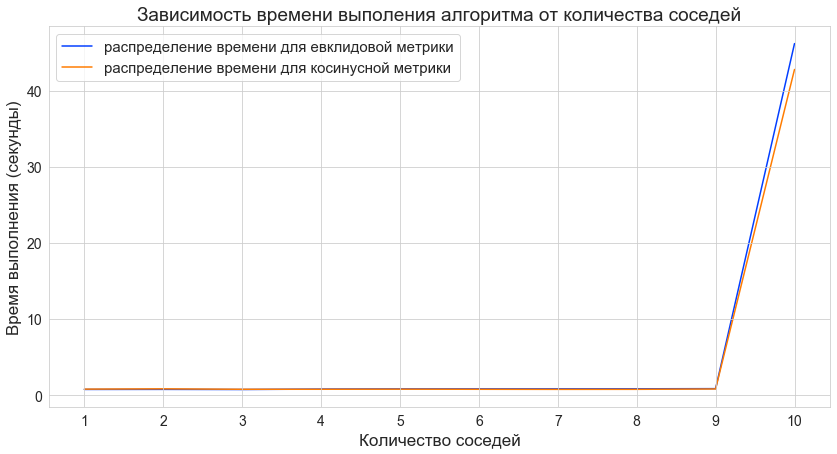

In [179]:
fig = plt.figure(figsize= (14,7))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость времени выполения алгоритма от количества соседей", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel("Время выполнения (секунды)", fontsize = 17)  
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
ax1.plot(k, time_arr, label = "распределение времени для евклидовой метрики")
ax1.plot(k, time_arr_cosine, label = "распределение времени для косинусной метрики")
ax1.legend(fontsize = 15)

In [180]:
fig.savefig('exersize_2_1.pdf')

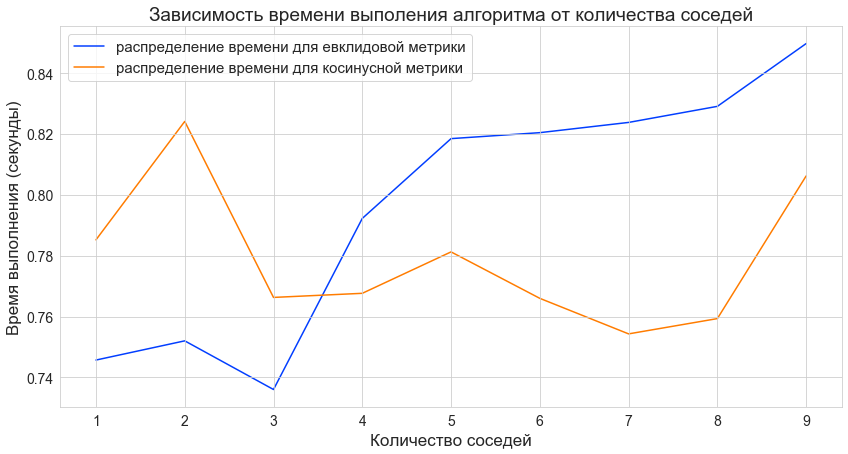

In [181]:
fig = plt.figure(figsize= (14,7))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость времени выполения алгоритма от количества соседей", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel("Время выполнения (секунды)", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
ax1.plot(k[:9], time_arr[:9], label = "распределение времени для евклидовой метрики")
ax1.plot(k[:9], time_arr_cosine[:9], label = "распределение времени для косинусной метрики")
ax1.legend(fontsize = 15)

In [182]:
fig.savefig('exersize_2_2.pdf')

In [167]:
euclidean_accur = np.zeros(10)

In [168]:
for n in accuracy_dict.keys():
    euclidean_accur[n - 1] = accuracy_dict[n].mean()

In [169]:
cosine_accur = np.zeros(10)

In [170]:
for n in accuracy_dict_cosine.keys():
    cosine_accur[n - 1] = accuracy_dict_cosine[n].mean()

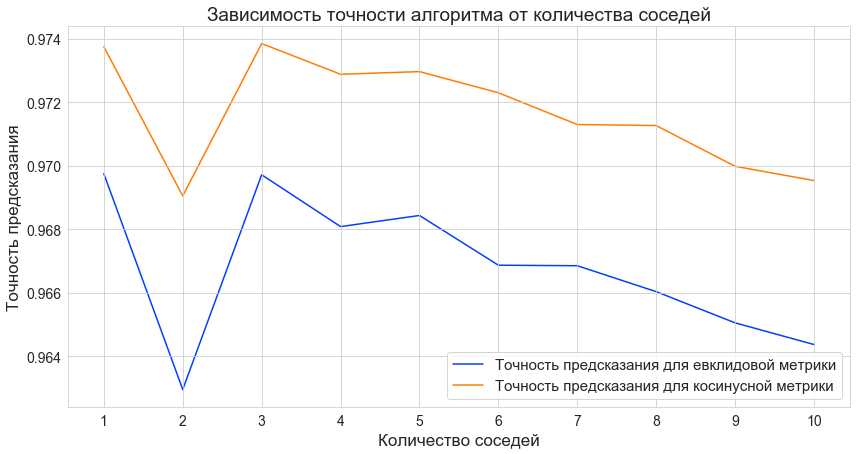

In [183]:
fig = plt.figure(figsize= (14,7))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость точности алгоритма от количества соседей", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel("Точность предсказания", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
ax1.plot(k, euclidean_accur, label = "Точность предсказания для евклидовой метрики")
ax1.plot(k, cosine_accur, label = "Точность предсказания для косинусной метрики")
ax1.legend(fontsize = 15)

In [184]:
fig.savefig('exersize_2_3.pdf')

# 3 задание

In [192]:
accuracy_weighted_euclid, time_weighted_euclid = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                                                                     cv = None, strategy = 'brute', metric = 'euclidean', 
                                                                     weights = True, test_block_size = 200)

In [193]:
weighted_euclidean_accur = np.zeros(10)
for n in accuracy_weighted_euclid.keys():
    weighted_euclidean_accur[n - 1] = accuracy_weighted_euclid[n].mean()

In [219]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(X_train, y_train, k, score = 'accuracy', 
                                                                     cv = None, strategy = 'brute', metric = 'cosine', 
                                                                     weights = True, test_block_size = 200)

In [195]:
weighted_cosine_accur = np.zeros(10)
for n in accuracy_weighted_cosine.keys():
    weighted_cosine_accur[n - 1] = accuracy_weighted_cosine[n].mean()

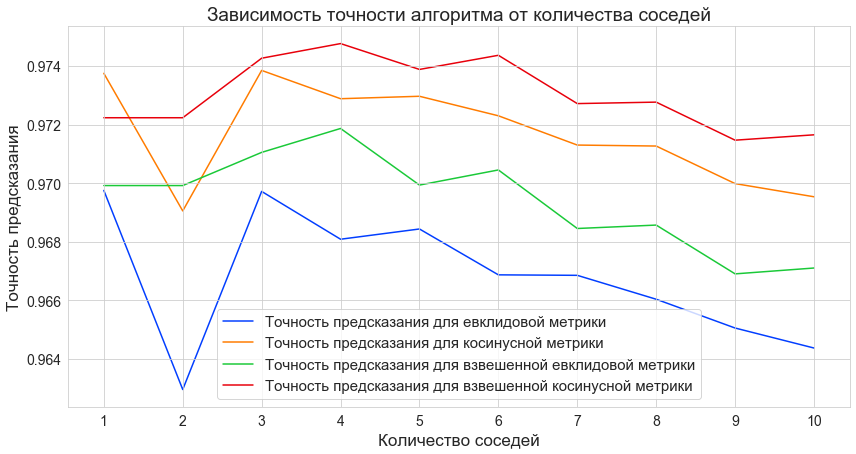

In [197]:
fig = plt.figure(figsize= (14,7))
ax1 = fig.add_subplot(111)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.title("Зависимость точности алгоритма от количества соседей", fontsize = 19)
plt.xlabel("Количество соседей", fontsize = 17) 
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
plt.ylabel("Точность предсказания", fontsize = 17) 
sns.set_style("whitegrid", {'axes.axisbelow': False, 'axes.grid': True})
ax1.plot(k, euclidean_accur, label = "Точность предсказания для евклидовой метрики")
ax1.plot(k, cosine_accur, label = "Точность предсказания для косинусной метрики")
ax1.plot(k, weighted_euclidean_accur, label = "Точность предсказания для взвешенной евклидовой метрики")
ax1.plot(k, weighted_cosine_accur, label = "Точность предсказания для взвешенной косинусной метрики")
ax1.legend(fontsize = 15)

In [198]:
fig.savefig('exersize_3.pdf')

# 4 задание

In [220]:
accuracy_weighted_cosine

{10: array([0.9728 , 0.97   , 0.97215]),
 9: array([0.9719 , 0.96995, 0.9724 ]),
 8: array([0.97315, 0.97175, 0.97415]),
 7: array([0.9731, 0.9717, 0.9737]),
 6: array([0.97485, 0.9734 , 0.97545]),
 5: array([0.9742 , 0.97255, 0.97505]),
 4: array([0.97535, 0.97455, 0.9763 ]),
 3: array([0.97505, 0.97335, 0.97585]),
 2: array([0.97325, 0.97275, 0.97395]),
 1: array([0.97325, 0.97275, 0.97395])}

In [216]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [217]:
accuracy(y_pred, y_test)

0.9752

Хороший результат. Лучше, чем на валидационной. Хуже, чем при использовании сверточных сетей. 0,89%

In [ ]:
matrix = confusion_matrix(y_test, y_pred)

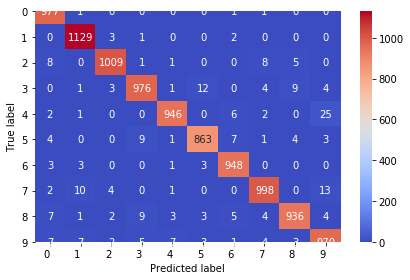

In [15]:
fig = plt.figure()
df_cm = pd.DataFrame(matrix)
heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap= 'coolwarm')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
fig.savefig('Exersize_4.pdf')

In [35]:
X_false = X_test[y_test != y_pred]
y_true = y_test[y_test != y_pred]
y_false = y_pred[y_test != y_pred]

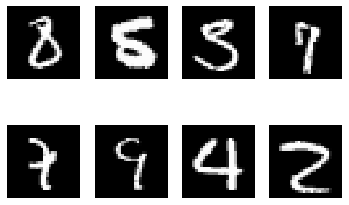

In [33]:
fig = plt.figure()
ax1 = fig.add_subplot(241)
ax2 = fig.add_subplot(242) 
ax3 = fig.add_subplot(243)  
ax4 = fig.add_subplot(244)  
ax5 = fig.add_subplot(245)
ax6 = fig.add_subplot(246) 
ax7 = fig.add_subplot(247)  
ax8 = fig.add_subplot(248)  
ax1.imshow(X_false[14].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax2.imshow(X_false[78].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax3.imshow(X_false[21].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax4.imshow(X_false[56].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax5.imshow(X_false[12].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax6.imshow(X_false[34].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax7.imshow(X_false[45].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax8.imshow(X_false[66].reshape(28, 28), cmap=plt.get_cmap('gray'))
ax1.axis("off")
ax2.axis("off")
ax3.axis("off")
ax4.axis("off")
ax5.axis("off")
ax6.axis("off")
ax7.axis("off")
ax8.axis("off")
plt.show()

In [37]:
fig.savefig('exersize_4_1.pdf')

In [36]:
print(y_true[14], y_false[14])
print(y_true[78], y_false[78])
print(y_true[21], y_false[21])
print(y_true[56], y_false[56])
print(y_true[12], y_false[12])
print(y_true[34], y_false[34])
print(y_true[45], y_false[45])
print(y_true[66], y_false[66])

8 3.0
5 8.0
3 5.0
7 9.0
7 1.0
9 4.0
4 9.0
2 7.0


# 5 задание

In [9]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_5_X_train = np.vstack((X_train, rotated_images))
rotated_5_y_train = np.hstack((y_train, y_train))

In [89]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 355, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_355_X_train = np.vstack((X_train, rotated_images))
rotated_355_y_train = np.hstack((y_train, y_train))

In [90]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 10, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_10_X_train = np.vstack((X_train, rotated_images))
rotated_10_y_train = np.hstack((y_train, y_train))

In [91]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 350, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_350_X_train = np.vstack((X_train, rotated_images))
rotated_350_y_train = np.hstack((y_train, y_train))

In [92]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 15, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_15_X_train = np.vstack((X_train, rotated_images))
rotated_15_y_train = np.hstack((y_train, y_train))

In [93]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 345, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_345_X_train = np.vstack((X_train, rotated_images))
rotated_345_y_train = np.hstack((y_train, y_train))

In [95]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_5_X_train, rotated_5_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.99025, 0.99   , 0.98955])}

In [96]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_10_X_train, rotated_10_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98305 , 0.982825, 0.982075])}

In [98]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_15_X_train, rotated_15_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.978125, 0.9777  , 0.97675 ])}

In [99]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_355_X_train, rotated_355_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98995, 0.9896 , 0.99015])}

In [100]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_350_X_train, rotated_350_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98375 , 0.982275, 0.982575])}

In [101]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(rotated_345_X_train, rotated_345_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.976775, 0.976925, 0.9785  ])}

In [109]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [1, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_10_X_train = np.vstack((X_train, shifted_images))
shifted_10_y_train = np.hstack((y_train, y_train))

In [110]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [2, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_20_X_train = np.vstack((X_train, shifted_images))
shifted_20_y_train = np.hstack((y_train, y_train))

In [111]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [3, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_30_X_train = np.vstack((X_train, shifted_images))
shifted_30_y_train = np.hstack((y_train, y_train))

In [112]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 1])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_01_X_train = np.vstack((X_train, shifted_images))
shifted_01_y_train = np.hstack((y_train, y_train))

In [113]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 2])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_02_X_train = np.vstack((X_train, shifted_images))
shifted_02_y_train = np.hstack((y_train, y_train))

In [114]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 3])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_03_X_train = np.vstack((X_train, shifted_images))
shifted_03_y_train = np.hstack((y_train, y_train))

In [115]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_10_X_train, shifted_10_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98295, 0.98205, 0.9826 ])}

In [116]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_20_X_train, shifted_20_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.9777  , 0.97665 , 0.974725])}

In [117]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_30_X_train, shifted_30_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.97565 , 0.9746  , 0.975725])}

In [118]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_01_X_train, shifted_01_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98265, 0.98225, 0.9822 ])}

In [119]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_02_X_train, shifted_02_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.97655, 0.9755 , 0.9761 ])}

In [120]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(shifted_03_X_train, shifted_03_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.976225, 0.974175, 0.975475])}

In [185]:
gaussian_images = []
for X_obj in X_train:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

gaussian_05_X_train = np.vstack((X_train, gaussian_images))
gaussian_05_y_train = np.hstack((y_train, y_train))

In [186]:
gaussian_images = []
for X_obj in X_train:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 1)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

gaussian_1_X_train = np.vstack((X_train, gaussian_images))
gaussian_1_y_train = np.hstack((y_train, y_train))

In [187]:
gaussian_images = []
for X_obj in X_train:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 1.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

gaussian_15_X_train = np.vstack((X_train, gaussian_images))
gaussian_15_y_train = np.hstack((y_train, y_train))

In [188]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(gaussian_05_X_train, gaussian_05_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

In [189]:
accuracy_weighted_cosine

{4: array([0.99245, 0.99315, 0.99285])}

In [190]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(gaussian_1_X_train, gaussian_1_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98755, 0.9885 , 0.9882 ])}

In [191]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(gaussian_15_X_train, gaussian_15_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98105, 0.9811 , 0.9805 ])}

In [34]:
rotated_images = []
for X_obj in X_train[:20000]:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

new_X_train = np.vstack((X_train, rotated_images))
new_y_train = np.hstack((y_train, y_train[:20000]))

In [35]:
shifted_images = []
for X_obj in X_train[20000:40000]:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 1])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

new_X_train = np.vstack((new_X_train, shifted_images))
new_y_train = np.hstack((new_y_train, y_train[20000:40000]))

In [36]:
gaussian_images = []
for X_obj in X_train[40000:]:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

new_X_train = np.vstack((new_X_train, gaussian_images))
new_y_train = np.hstack((new_y_train, y_train[40000:]))

In [37]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(new_X_train, new_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9751

In [38]:
rotated_images = []
for X_obj in X_train[:30000]:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

new_X_train = np.vstack((X_train, rotated_images))
new_y_train = np.hstack((y_train, y_train[:30000]))

shifted_images = []
for X_obj in X_train[30000:]:
    shifted = sc.shift(X_obj.reshape(28, 28), [1, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

new_X_train = np.vstack((new_X_train, shifted_images))
new_y_train = np.hstack((new_y_train, y_train[30000:]))

In [39]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(new_X_train, new_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9753

In [40]:
rotated_images = []
for X_obj in X_train[:30000]:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

new_X_train = np.vstack((X_train, rotated_images))
new_y_train = np.hstack((y_train, y_train[:30000]))

gaussian_images = []
for X_obj in X_train[30000:]:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

new_X_train = np.vstack((new_X_train, gaussian_images))
new_y_train = np.hstack((new_y_train, y_train[30000:]))

In [41]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(new_X_train, new_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9753

In [42]:
shifted_images = []
for X_obj in X_train[:30000]:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 1])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

new_X_train = np.vstack((new_X_train, shifted_images))
new_y_train = np.hstack((new_y_train, y_train[:30000]))

gaussian_images = []
for X_obj in X_train[30000:]:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

new_X_train = np.vstack((new_X_train, gaussian_images))
new_y_train = np.hstack((new_y_train, y_train[30000:]))

In [43]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(new_X_train, new_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9749

In [214]:
added_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    gaussian = sc.gaussian_filter(rotated, 0.5)
    added_images.append(np.ravel(gaussian))
    
added_images = np.array(added_images)

new_X_train = np.vstack((X_train, added_images))
new_y_train = np.hstack((y_train, y_train))

In [215]:
accuracy_weighted_cosine, time_weighted_cosine = knn_cross_val_score(new_X_train, new_y_train, k_list = [4], 
                                                                     score = 'accuracy', cv = None, strategy = 'brute', 
                                                                     metric = 'cosine', weights = True, test_block_size = 200)

accuracy_weighted_cosine

{4: array([0.98935, 0.98945, 0.99085])}

## Вот здесь запускать

In [ ]:
rotated_images = []
for X_obj in X_train:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_images = np.array(rotated_images)

rotated_5_X_train = np.vstack((X_train, rotated_images))
rotated_5_y_train = np.hstack((y_train, y_train))

In [10]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(rotated_5_X_train, rotated_5_y_train)
y_pred = classifier.predict(X_test)

In [11]:
accuracy(y_pred, y_test)

0.976

In [12]:
matrix = confusion_matrix(y_test, y_pred)

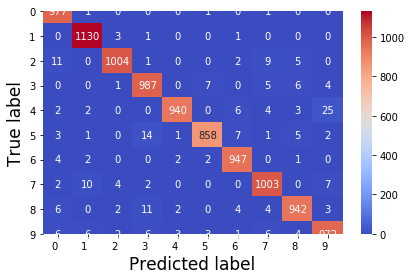

In [15]:
fig = plt.figure()
df_cm = pd.DataFrame(matrix)
heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap= 'coolwarm')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label', fontsize = 17)
plt.xlabel('Predicted label', fontsize = 17)
plt.tight_layout()
plt.show()

In [19]:
fig.savefig('exersize_5_1.pdf')

In [26]:
shifted_images = []
for X_obj in X_train:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 1])
    shifted_images.append(np.ravel(shifted))
    
shifted_images = np.array(shifted_images)

shifted_01_X_train = np.vstack((X_train, shifted_images))
shifted_01_y_train = np.hstack((y_train, y_train))

In [27]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(shifted_01_X_train, shifted_01_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9759

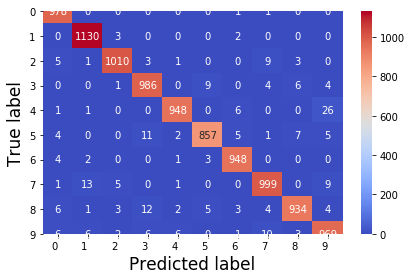

In [28]:
matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure()
df_cm = pd.DataFrame(matrix)
heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap= 'coolwarm')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label', fontsize = 17)
plt.xlabel('Predicted label', fontsize = 17)
plt.tight_layout()
plt.show()

In [29]:
fig.savefig('exersize_5_2.pdf')

In [30]:
gaussian_images = []
for X_obj in X_train:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_images = np.array(gaussian_images)

gaussian_05_X_train = np.vstack((X_train, gaussian_images))
gaussian_05_y_train = np.hstack((y_train, y_train))

In [31]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(gaussian_05_X_train, gaussian_05_y_train)
y_pred = classifier.predict(X_test)

accuracy(y_pred, y_test)

0.9758

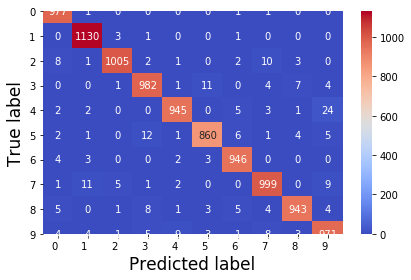

In [32]:
matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure()
df_cm = pd.DataFrame(matrix)
heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap= 'coolwarm')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label', fontsize = 17)
plt.xlabel('Predicted label', fontsize = 17)
plt.tight_layout()
plt.show()

In [33]:
fig.savefig('exersize_5_2.pdf')

# 6 задание

In [52]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 5, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_5_X_test = np.array(rotated_images)

In [53]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_5_X_test)

accuracy(y_pred, y_test)

0.9737

In [54]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 10, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_10_X_test = np.array(rotated_images)

In [55]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_10_X_test)

accuracy(y_pred, y_test)

0.9652

In [56]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 15, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_15_X_test = np.array(rotated_images)

In [57]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_15_X_test)

accuracy(y_pred, y_test)

0.9461

In [58]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 355, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_355_X_test = np.array(rotated_images)

In [59]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_355_X_test)

accuracy(y_pred, y_test)

0.9744

In [60]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 350, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_350_X_test = np.array(rotated_images)

In [61]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_350_X_test)

accuracy(y_pred, y_test)

0.9692

In [62]:
rotated_images = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 345, reshape=False)
    rotated_images.append(np.ravel(rotated))
    
rotated_345_X_test = np.array(rotated_images)

In [63]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_345_X_test)

accuracy(y_pred, y_test)

0.9491

In [64]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [1, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_10_X = np.array(shifted_images)

In [65]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_10_X)

accuracy(y_pred, y_test)

0.9548

In [66]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [2, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_20_X = np.array(shifted_images)

In [67]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_20_X)

accuracy(y_pred, y_test)

0.84

In [68]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [3, 0])
    shifted_images.append(np.ravel(shifted))
    
shifted_30_X = np.array(shifted_images)

In [69]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_30_X)

accuracy(y_pred, y_test)

0.5773

In [70]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 1])
    shifted_images.append(np.ravel(shifted))
    
shifted_01_X = np.array(shifted_images)

In [71]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_01_X)

accuracy(y_pred, y_test)

0.9482

In [72]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 2])
    shifted_images.append(np.ravel(shifted))
    
shifted_02_X = np.array(shifted_images)

In [73]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_02_X)

accuracy(y_pred, y_test)

0.7897

In [74]:
shifted_images = []
for X_obj in X_test:
    shifted = sc.shift(X_obj.reshape(28, 28), [0, 3])
    shifted_images.append(np.ravel(shifted))
    
shifted_03_X = np.array(shifted_images)

In [75]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(shifted_03_X)

accuracy(y_pred, y_test)

0.6086

In [76]:
gaussian_images = []
for X_obj in X_test:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 0.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_05_X = np.array(gaussian_images)

In [77]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(gaussian_05_X)

accuracy(y_pred, y_test)

0.9738

In [78]:
gaussian_images = []
for X_obj in X_test:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 1)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_1_X = np.array(gaussian_images)

In [79]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(gaussian_1_X)

accuracy(y_pred, y_test)

0.9613

In [80]:
gaussian_images = []
for X_obj in X_test:
    gaussian = sc.gaussian_filter(X_obj.reshape(28, 28), 1.5)
    gaussian_images.append(np.ravel(gaussian))
    
gaussian_15_X = np.array(gaussian_images)

In [81]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(gaussian_15_X)

accuracy(y_pred, y_test)

0.9191

In [82]:
rotated_gauss = []
for X_obj in X_test:
    rotated = sc.rotate(X_obj.reshape(28, 28), 355, reshape=False)
    gaussian = sc.gaussian_filter(rotated, 0.5)
    rotated_gauss.append(np.ravel(gaussian))
    
rotated_gauss_X_test = np.array(rotated_gauss)

In [83]:
classifier = KNNClassifier(k = 4, strategy = 'brute', metric = 'cosine', weights = True, test_block_size = 200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(rotated_gauss_X_test)

accuracy(y_pred, y_test)

0.973

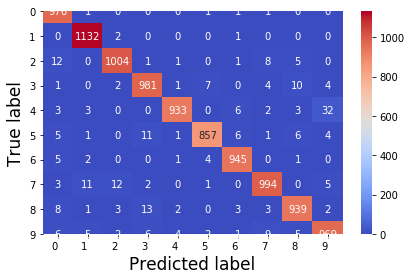

In [84]:
matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure()
df_cm = pd.DataFrame(matrix)
heatmap = sns.heatmap(df_cm, annot = True, fmt = "d", cmap= 'coolwarm')
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation = 0, ha = 'right')
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=0, ha='right')
plt.ylabel('True label', fontsize = 17)
plt.xlabel('Predicted label', fontsize = 17)
plt.tight_layout()
plt.show()

In [85]:
fig.savefig('exersize_6.pdf')